<a href="https://www.kaggle.com/code/jaskafrans880/auto-claim-analysis?scriptVersionId=263825345" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Auto-Claim Genius: An AI-Powered Insurance Claims Resolution Engine

### Problem Statement
The auto insurance industry is inundated with a complex mix of structured and unstructured data, from policy details and vehicle specifications to raw accident images and textual descriptions. The traditional process of manually reviewing this data to assess damage, determine fault, and estimate repair costs is notoriously slow, inconsistent, and resource-intensive. This inefficiency creates a significant operational bottleneck, leading to delayed resolutions, increased costs, and a frustrating customer experience. The core problem is not a lack of data, but the inability to unlock and synthesize insights from these varied formats at scale.

### Impact Statement
Auto-Claim Genius directly addresses this challenge by creating an end-to-end, AI-driven workflow within Google BigQuery. Our solution transforms the claims process from a manual, multi-day task into a streamlined, automated analysis. The material impact is a significant **reduction in claim cycle times**, a **decrease in operational overhead**, and a **dramatic improvement in the consistency and accuracy of initial damage assessments**. This allows claims adjusters to focus their expertise on the most complex cases, leading to faster payouts, reduced fraud, and ultimately, higher customer satisfaction and retention.

---

## Solution Overview & Technical Walkthrough

Auto-Claim Genius is a working prototype that demonstrates how BigQuery's native AI capabilities can build an intelligent business application directly on top of a data warehouse. Our solution follows a three-phase process to turn raw, mixed-format data into polished, actionable business intelligence.

### Phase 1: Data Preparation & Multimodal Enrichment
This phase addresses the challenge of combining disparate data sources into a single, analysis-ready master table. We heavily utilized **BigFrames**, the Python API for BigQuery, to perform large-scale data manipulation without moving data out of the warehouse.

*   **Unified Data Loading:** We began by loading our structured tables (`Claims`, `Policies`, `Vehicles`, `Policyholders`) and unstructured data sources (`claim_images_raw`, `Image_Claims_Analysis`) into BigFrames DataFrames.
*   **Multimodal Fusion:** We then performed a series of joins to create a master feature table. This process seamlessly combines structured data (e.g., `accident_type`, `vehicle_age`) with unstructured data (the text description of accident images), a core tenet of the **Multimodal Pioneer** approach.
*   **Feature Engineering:** We derived new, valuable features directly in BigQuery, such as `days_to_file_claim` and `composite_risk_score`, to provide richer context for our AI models.

### Phase 2: AI-Powered Prediction of Key Claim Attributes
This is the heart of our solution and a direct implementation of the **AI Architect** approach. The goal was to use generative AI to intelligently predict and fill in the five critical, but often missing, columns in our claims dataset.

*   **Contextual Prompting:** For each claim, we dynamically constructed a rich, contextual prompt. This prompt provided the Gemini model with a comprehensive summary of the incident, including structured data points and the unstructured text analysis of the accident image.
*   **Generative Prediction with Gemini:** We used `bigframes.ml.llm.GeminiTextGenerator` to analyze this prompt and generate predictions for the five target fields:
    *   `airbag_deployed` (True/False)
    *   `drivable_post_accident` (True/False)
    *   `predicted_damage_severity` (Low, Medium, or High)
    *   `predicted_quote` (A specific USD amount)
    *   `damage_location` (e.g., Front Bumper)
*   **Robust Parsing:** To ensure data quality, we applied robust parsing techniques using regular expressions (`regex`) to extract the structured information from the model's text output and populate our final DataFrame.

### 🎥 Project Demo Video

To provide a comprehensive overview of our solution, we have created a short video walkthrough. It covers the business problem, our technical approach using BigQuery and Gemini, and a live demonstration of the final **Auto-Claim Genius** dashboard.

<br>

<div align="center">
  <a href="https://youtu.be/4sbTupsdsmI">
    <img src="https://i.imgur.com/your-thumbnail-image.png" alt="Watch the Demo Video" width="700">
  </a>
  <p><strong><a href="https://youtu.be/4sbTupsdsmI">Click Here to Watch the Full Demo on YouTube</a></strong></p>
</div>

<br>

### 📄 Project Source Code on GitHub

The complete Jupyter Notebook for this project is available for review in our public GitHub repository.

**[Link to Notebook: auto-claim-analysis.ipynb](https://github.com/jaskaransinghkohli/BigQueryAutoAnalysis/blob/main/auto-claim-analysis.ipynb)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigquery-ai-hackathon/survey.txt


In [2]:
!pip install google-cloud-bigquery[bqstorage]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
print("Step 1 complete. Now RESTART the kernel (Runtime -> Restart Runtime)")
print("Then run Cell 2 below.")

Step 1 complete. Now RESTART the kernel (Runtime -> Restart Runtime)
Then run Cell 2 below.


In [4]:
# !pip install --upgrade google-cloud-bigquery==3.31.0
# !pip install rich==13.7.1


### **Connecting to BigQuery: A Universal Approach**

To ensure this notebook is fully reproducible for both the project editors and the Kaggle judges, we've implemented a robust, dual-path connection method. This initial code block handles all authentication and client initialization for the entire session.

**How it Works:**

1.  **Editor Mode (Private Access):** The code first attempts to connect using Kaggle Secrets. If a `GOOGLE_APPLICATION_CREDENTIALS` secret is found, it establishes a secure connection using our private service account. This is the path used during development.

2.  **Public Mode (Public Access):** If the secret is not found (which will be the case for judges and public viewers), the code gracefully falls back to Kaggle's default user authentication. This method will work seamlessly and without requiring any setup from the user, provided that our project's BigQuery dataset (`bqhackathonautoianalysis.autoAnalysis_Dataset`) has been made publicly accessible with the "BigQuery Data Viewer" role.

This approach guarantees that anyone can run the notebook from top to bottom, either leveraging private credentials if available or using public, read-only access to the data, ensuring a smooth and error-free evaluation experience.

In [5]:
# ===================================================================
# DUAL-PATH BIGQUERY CONNECTION FOR KAGGLE NOTEBOOKS
# -------------------------------------------------------------------
# This cell creates a robust connection that works in two modes:
# 1. EDITOR MODE: If Kaggle Secrets are available, it uses them for
#    private, authenticated access.
# 2. PUBLIC MODE: If secrets are NOT found, it falls back to public
#    authentication, which works for judges and public viewers if the
#    dataset is public.
# ===================================================================

# --- Step 1: Necessary Imports ---
import os
from google.colab import auth
from google.cloud import bigquery
import bigframes.pandas as bf
from kaggle_secrets import UserSecretsClient

# --- Step 2: Define Project Constants ---
project_id = "bqhackathonautoianalysis"
location = "us-central1"

# --- Step 3: Clean up any previous BigFrames session ---
# This prevents hanging issues on re-runs.
try:
    bf.close_session()
except Exception:
    pass

# --- Step 4: Attempt Authentication ---
print("Attempting to connect to BigQuery...")
client = None
auth_method = "Unknown"

try:
    # --- PATH 1: EDITOR MODE (using Kaggle Secrets) ---
    print("  -> Trying Editor Mode (using Kaggle Secrets)...")
    
    user_secrets = UserSecretsClient()
    service_account_info = user_secrets.get_secret("GOOGLE_APPLICATION_CREDENTIALS")
    
    # Write the secret to a temporary file
    with open('/tmp/service-account-key.json', 'w') as f:
        f.write(service_account_info)
    
    # Set the environment variable for automatic authentication
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/tmp/service-account-key.json'
    
    # Initialize clients (they will automatically use the environment variable)
    client = bigquery.Client(project=project_id)
    bf.options.bigquery.project = project_id
    bf.options.bigquery.location = location
    
    auth_method = "Kaggle Secrets"
    print("✅ Successfully connected using Editor Mode (Kaggle Secrets).")

except Exception:
    # --- PATH 2: PUBLIC MODE (using default authentication) ---
    print("  -> Kaggle Secrets not found. Falling back to Public Mode...")
    
    try:
        # Authenticate the user for the session (triggers pop-up for owner, automatic for public)
        auth.authenticate_user()
        
        # Explicitly get the credentials to pass to the clients
        credentials, _ = auth.default()

        client = bigquery.Client(project=project_id, credentials=credentials)
        bf.options.bigquery.project = project_id
        bf.options.bigquery.location = location
        bf.options.bigquery.credentials = credentials
        
        auth_method = "Public Authentication"
        print("✅ Successfully connected using Public Mode.")
        
    except Exception as e:
        print(f"❌ Public authentication also failed. Error: {e}")
        auth_method = "Failed"

# --- Step 5: Final Connection Test ---
if client:
    try:
        test_query = f"SELECT COUNT(*) as total_rows FROM `{project_id}.autoAnalysis_Dataset.Claims`"
        result = client.query(test_query).to_dataframe()
        print("\n---------------------------------------------------------")
        print(f"🎉 SUCCESS! Connection established via '{auth_method}'.")
        print(f"Total rows in the Claims table: {result['total_rows'].iloc[0]}")
        print("---------------------------------------------------------")
    except Exception as e:
        print(f"❌ Connection test failed after authenticating via '{auth_method}'.")
        print(f"   Error: {e}")
else:
    print("\n❌ Could not establish a BigQuery client.")
    print("\nTroubleshooting:")
    print("  - For Editors: Ensure your Kaggle secret is named 'GOOGLE_APPLICATION_CREDENTIALS'.")
    print("  - For Public Users/Judges: The dataset 'bqhackathonautoianalysis.autoAnalysis_Dataset' must be made public.")

# ===================================================================

Attempting to connect to BigQuery...
  -> Trying Editor Mode (using Kaggle Secrets)...
✅ Successfully connected using Editor Mode (Kaggle Secrets).

---------------------------------------------------------
🎉 SUCCESS! Connection established via 'Kaggle Secrets'.
Total rows in the Claims table: 70
---------------------------------------------------------


In [6]:
sql = """
SELECT * FROM `bqhackathonautoianalysis.autoAnalysis_Dataset.Policies` 
"""
df = client.query(sql).to_dataframe()
df

,policy_id,policyholder_id,vin,start_date,end_date,premium_amount,deductible_amount,coverage_limit,policy_type
0,PLCY-365737,PH-64503,ZGY7WL956RJ516023,2024-06-07,2025-06-07,1233.52,250.0,75000.0,Collision
1,PLCY-205899,PH-10053,4KLW00K34GU905842,2023-10-24,2024-10-23,1188.96,250.0,100000.0,Collision
2,PLCY-503004,PH-51346,3PRU6FJM2JM866469,2023-11-06,2024-11-05,852.58,250.0,75000.0,Collision
3,PLCY-599856,PH-54783,2NMFZ6LT6RK320517,2023-10-06,2024-10-05,1017.26,250.0,25000.0,Collision
4,PLCY-562791,PH-39886,ZRDL46SB4LF706133,2023-12-17,2024-12-16,1063.60,250.0,50000.0,Collision
...,...,...,...,...,...,...,...,...,...
65,PLCY-192524,PH-83001,4AHMDLLR4CB340093,2023-12-30,2024-12-29,1242.62,1000.0,50000.0,Liability
66,PLCY-901441,PH-96423,2RD942G8XYD262536,2024-08-13,2025-08-13,776.96,1000.0,25000.0,Liability
67,PLCY-620218,PH-85707,SCL8W03G4JD592597,2024-05-07,2025-05-07,1035.88,1000.0,75000.0,Liability
68,PLCY-630841,PH-60293,4BAX5HWD6FH046845,2024-03-22,2025-03-22,1374.67,1000.0,50000.0,Liability


List of all the tables in DB.

In [7]:
# Query 2: List all tables in the dataset
query_tables = """
SELECT table_name
FROM `bqhackathonautoianalysis.autoAnalysis_Dataset.INFORMATION_SCHEMA.TABLES`
ORDER BY table_name
"""
df_tables = client.query(query_tables).to_dataframe()
print(df_tables)

                           table_name
0                              Claims
1         Claims_Complete_Predictions
2              Claims_Master_Features
3               FINAL_Claims_Complete
4             FINAL_Executive_Summary
5                FINAL_Image_Analysis
6               Image_Claims_Analysis
7                            Policies
8                       Policyholders
9   TEMP_RAW_AI_RESULTS_session7c941b
10                           Vehicles
11                       claim_images
12                   claim_images_raw
13             image_analysis_results
14  temp_ai_raw_results_session7c941b


In [8]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize BigQuery client
project_id = "bqhackathonautoianalysis"
bq_client = bigquery.Client(project=project_id)

# Define table names
tables = {
    "Image Claims": "Image_Claims_Analysis",
    "Vehicles": "Vehicles", 
    "Claims": "Claims",
    "Policies": "Policies",
    "Policyholders": "Policyholders"
}

def clean_dataframe_simple(df):
    """Simple cleaning without fillna - just handle infinities"""
    # Replace infinite values with NaN (but don't fill)
    df.replace([float('inf'), float('-inf')], np.nan, inplace=True)
    return df

# Alternative: Query with explicit handling in SQL
def get_table_with_coalesce(table_name):
    """Get table data with SQL-level null handling"""
    full_table = f"{project_id}.autoAnalysis_Dataset.{table_name}"
    
    # First, get column info
    info_query = f"""
    SELECT column_name, data_type 
    FROM `{project_id}.autoAnalysis_Dataset.INFORMATION_SCHEMA.COLUMNS` 
    WHERE table_name = '{table_name}'
    """
    
    try:
        col_info = bq_client.query(info_query).to_dataframe()
        
        # Build select statement with appropriate defaults
        select_parts = []
        for _, row in col_info.iterrows():
            col_name = row['column_name']
            data_type = row['data_type'].upper()
            
            if 'BOOL' in data_type:
                select_parts.append(f"COALESCE({col_name}, FALSE) as {col_name}")
            elif any(x in data_type for x in ['INT', 'FLOAT', 'NUMERIC']):
                select_parts.append(f"COALESCE({col_name}, 0) as {col_name}")
            elif 'STRING' in data_type:
                select_parts.append(f"COALESCE({col_name}, '') as {col_name}")
            else:
                select_parts.append(col_name)  # Leave as is
        
        query = f"SELECT {', '.join(select_parts)} FROM `{full_table}`"
        return bq_client.query(query).to_dataframe()
        
    except Exception as e:
        print(f"Could not get column info for {table_name}: {e}")
        # Fallback to simple query
        query = f"SELECT * FROM `{full_table}`"
        return bq_client.query(query).to_dataframe()

# Query and display each table
for name, table in tables.items():
    print(f"\n=== {name.upper()} ===")
    
    try:
        # Try the SQL-level approach first
        df = get_table_with_coalesce(table)
        
        # Simple cleaning
        df = clean_dataframe_simple(df)
        
        print(f"Successfully loaded {name}")
        display(df.head())
        print(f"Shape: {df.shape}")
        print(f"Data types:")
        print(df.dtypes)
        print(f"Null values per column:")
        print(df.isnull().sum())
        
    except Exception as e:
        print(f"Error loading {name}: {e}")
        
        # Try simple fallback approach
        try:
            full_table = f"{project_id}.autoAnalysis_Dataset.{table}"
            query = f"SELECT * FROM `{full_table}`"
            df = bq_client.query(query).to_dataframe()
            
            print(f"Fallback successful for {name} (with null values)")
            display(df.head())
            print(f"Shape: {df.shape}")
            print(f"Null values per column:")
            print(df.isnull().sum())
            
        except Exception as e2:
            print(f"Complete failure for {name}: {e2}")
            continue


=== IMAGE CLAIMS ===
Successfully loaded Image Claims


,image_number,claim_id,image_uri,full_response,identified_make,identified_model,identified_damage_severity,confidence_score,identified_damage_type
0,32,CL-8032,gs://auto_insurance_analysis/Images_BigQuery/3...,Audi A3,Audi,A3,,0.0,
1,37,CL-8037,gs://auto_insurance_analysis/Images_BigQuery/3...,Audi A8 L,Audi,A8 L,,0.0,
2,23,CL-8023,gs://auto_insurance_analysis/Images_BigQuery/2...,BMW,BMW,,,0.0,
3,30,CL-8030,gs://auto_insurance_analysis/Images_BigQuery/3...,BMW 3 Series,BMW,3 Series,,0.0,
4,26,CL-8026,gs://auto_insurance_analysis/Images_BigQuery/2...,BMW 3 Series,BMW,3 Series,,0.0,


Shape: (70, 9)
Data types:
image_number                    Int64
claim_id                       object
image_uri                      object
full_response                  object
identified_make                object
identified_model               object
identified_damage_severity     object
confidence_score              float64
identified_damage_type         object
dtype: object
Null values per column:
image_number                  0
claim_id                      0
image_uri                     0
full_response                 0
identified_make               0
identified_model              0
identified_damage_severity    0
confidence_score              0
identified_damage_type        0
dtype: int64

=== VEHICLES ===
Successfully loaded Vehicles


,vin,make,model,year,color,vehicle_age,repair_vs_replace_flag
0,KHTJVKES3JV558271,BMW,3 Series,2010,Brown,15,
1,2NMFZ6LT6RK320517,Renault,Captur,2010,Gray,15,
2,SCL8W03G4JD592597,SE,,2010,Green,15,
3,NKLAMG0S6SS957555,Skoda,Fab,2010,Silver,15,
4,KCLVJNJ20GK965793,Toyota,Echo,2010,Brown,15,


Shape: (70, 7)
Data types:
vin                       object
make                      object
model                     object
year                       Int64
color                     object
vehicle_age                Int64
repair_vs_replace_flag    object
dtype: object
Null values per column:
vin                       0
make                      0
model                     0
year                      0
color                     0
vehicle_age               0
repair_vs_replace_flag    0
dtype: int64

=== CLAIMS ===
Successfully loaded Claims


,claim_id,policy_id,accident_date,claim_filed_date,accident_type,damage_location,weather_condition,airbag_deployed,drivable_post_accident,predicted_damage_severity,predicted_quote,vin
0,CL-8049,PLCY-605794,2025-04-13,2025-04-16,Parking Lot Incident,,Clear,,,,0.0,2GYF59A80FS958948
1,CL-804,PLCY-116161,2025-07-24,2025-07-26,Parking Lot Incident,,Clear,,,,0.0,4CL7Z05W5GK626891
2,CL-8080,PLCY-761488,2025-05-12,2025-05-15,Rear-end Collision,,Clear,,,,0.0,1STYXN902KH100728
3,CL-801,PLCY-630841,2025-08-09,2025-08-13,Rear-end Collision,,Clear,,,,0.0,4BAX5HWD6FH046845
4,CL-8062,PLCY-240570,2025-03-24,2025-03-25,Rear-end Collision,,Clear,,,,0.0,NKLAMG0S6SS957555


Shape: (70, 12)
Data types:
claim_id                      object
policy_id                     object
accident_date                 dbdate
claim_filed_date              dbdate
accident_type                 object
damage_location               object
weather_condition             object
airbag_deployed               object
drivable_post_accident        object
predicted_damage_severity     object
predicted_quote              float64
vin                           object
dtype: object
Null values per column:
claim_id                     0
policy_id                    0
accident_date                0
claim_filed_date             0
accident_type                0
damage_location              0
weather_condition            0
airbag_deployed              0
drivable_post_accident       0
predicted_damage_severity    0
predicted_quote              0
vin                          0
dtype: int64

=== POLICIES ===
Successfully loaded Policies


,policy_id,policyholder_id,vin,start_date,end_date,premium_amount,deductible_amount,coverage_limit,policy_type
0,PLCY-365737,PH-64503,ZGY7WL956RJ516023,2024-06-07,2025-06-07,1233.52,250.0,75000.0,Collision
1,PLCY-205899,PH-10053,4KLW00K34GU905842,2023-10-24,2024-10-23,1188.96,250.0,100000.0,Collision
2,PLCY-503004,PH-51346,3PRU6FJM2JM866469,2023-11-06,2024-11-05,852.58,250.0,75000.0,Collision
3,PLCY-599856,PH-54783,2NMFZ6LT6RK320517,2023-10-06,2024-10-05,1017.26,250.0,25000.0,Collision
4,PLCY-562791,PH-39886,ZRDL46SB4LF706133,2023-12-17,2024-12-16,1063.60,250.0,50000.0,Collision


Shape: (70, 9)
Data types:
policy_id             object
policyholder_id       object
vin                   object
start_date            dbdate
end_date              dbdate
premium_amount       float64
deductible_amount    float64
coverage_limit       float64
policy_type           object
dtype: object
Null values per column:
policy_id            0
policyholder_id      0
vin                  0
start_date           0
end_date             0
premium_amount       0
deductible_amount    0
coverage_limit       0
policy_type          0
dtype: int64

=== POLICYHOLDERS ===
Successfully loaded Policyholders


,policyholder_id,first_name,last_name,address,city,state,zip_code,signup_date,email,phone_number
0,PH-36676,Brandon,Scott,726 Carr Pass Suite 864,West Georgestad,AK,30652,2022-08-03,brandon.scott@example.com,(254)-289-7211
1,PH-64503,Stacey,Schroeder,6355 Lambert Manor,Meyerstad,AL,45774,2023-02-02,stacey.schroeder@example.com,(351)-381-2148
2,PH-33277,Kenneth,Jarvis,14858 Joseph Gardens Apt. 464,Port Dawnmouth,AL,90442,2024-03-25,kenneth.jarvis@example.com,(969)-837-5516
3,PH-69342,Robert,Delacruz,5972 Butler Oval Suite 522,New Johnmouth,AR,41122,2024-05-06,robert.delacruz@example.com,(428)-275-2485
4,PH-10053,Adam,Lopez,100 Melissa Square,New Toddfurt,CO,35304,2023-07-31,adam.lopez@example.com,(461)-465-5171


Shape: (70, 10)
Data types:
policyholder_id    object
first_name         object
last_name          object
address            object
city               object
state              object
zip_code            Int64
signup_date        dbdate
email              object
phone_number       object
dtype: object
Null values per column:
policyholder_id    0
first_name         0
last_name          0
address            0
city               0
state              0
zip_code           0
signup_date        0
email              0
phone_number       0
dtype: int64


Table Overview & Join Keys

In [9]:
from google.cloud import bigquery
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

project_id = "bqhackathonautoianalysis"
bq_client = bigquery.Client(project=project_id)
# List of tables and expected join keys
tables = {
    "Claims": "Claims",
    "Image_Claims_Analysis": "Image_Claims_Analysis",
    "Vehicles": "Vehicles",
    "Policies": "Policies",
    "Policyholders": "Policyholders"
}

# Display schema for each table
for name, table in tables.items():
    query = f"""
    SELECT column_name, data_type, is_nullable
    FROM `{project_id}.autoAnalysis_Dataset.INFORMATION_SCHEMA.COLUMNS`
    WHERE table_name = '{table}'
    ORDER BY column_name
    """
    schema_df = bq_client.query(query).to_dataframe()
    print(f"\n=== {name.upper()} SCHEMA ===")
    display(schema_df)



=== CLAIMS SCHEMA ===


,column_name,data_type,is_nullable
0,accident_date,DATE,YES
1,accident_type,STRING,YES
2,airbag_deployed,STRING,YES
3,claim_filed_date,DATE,YES
4,claim_id,STRING,YES
5,damage_location,STRING,YES
6,drivable_post_accident,STRING,YES
7,policy_id,STRING,YES
8,predicted_damage_severity,STRING,YES
9,predicted_quote,FLOAT64,YES



=== IMAGE_CLAIMS_ANALYSIS SCHEMA ===


,column_name,data_type,is_nullable
0,claim_id,STRING,YES
1,confidence_score,FLOAT64,YES
2,full_response,STRING,YES
3,identified_damage_severity,STRING,YES
4,identified_damage_type,STRING,YES
5,identified_make,STRING,YES
6,identified_model,STRING,YES
7,image_number,INT64,YES
8,image_uri,STRING,YES



=== VEHICLES SCHEMA ===


,column_name,data_type,is_nullable
0,color,STRING,YES
1,make,STRING,YES
2,model,STRING,YES
3,repair_vs_replace_flag,STRING,YES
4,vehicle_age,INT64,YES
5,vin,STRING,YES
6,year,INT64,YES



=== POLICIES SCHEMA ===


,column_name,data_type,is_nullable
0,coverage_limit,FLOAT64,YES
1,deductible_amount,FLOAT64,YES
2,end_date,DATE,YES
3,policy_id,STRING,YES
4,policy_type,STRING,YES
5,policyholder_id,STRING,YES
6,premium_amount,FLOAT64,YES
7,start_date,DATE,YES
8,vin,STRING,YES



=== POLICYHOLDERS SCHEMA ===


,column_name,data_type,is_nullable
0,address,STRING,YES
1,city,STRING,YES
2,email,STRING,YES
3,first_name,STRING,YES
4,last_name,STRING,YES
5,phone_number,STRING,YES
6,policyholder_id,STRING,YES
7,signup_date,DATE,YES
8,state,STRING,YES
9,zip_code,INT64,YES


Basic Column Profiling

In [10]:
# Load each table into a DataFrame
dfs = {}
for name, table in tables.items():
    query = f"SELECT * FROM `{project_id}.autoAnalysis_Dataset.{table}`"
    df = bq_client.query(query).to_dataframe()
    dfs[name] = df

# Profile each table
for name, df in dfs.items():
    print(f"\n=== {name.upper()} ===")
    display(df.head())
    print(df.info())
    print("Missing values:\n", df.isnull().sum())
    print("Unique values:\n", df.nunique())



=== CLAIMS ===


,claim_id,policy_id,accident_date,claim_filed_date,accident_type,damage_location,weather_condition,airbag_deployed,drivable_post_accident,predicted_damage_severity,predicted_quote,vin
0,CL-8049,PLCY-605794,2025-04-13,2025-04-16,Parking Lot Incident,None,Clear,None,None,None,NaN,2GYF59A80FS958948
1,CL-804,PLCY-116161,2025-07-24,2025-07-26,Parking Lot Incident,None,Clear,None,None,None,NaN,4CL7Z05W5GK626891
2,CL-8080,PLCY-761488,2025-05-12,2025-05-15,Rear-end Collision,None,Clear,None,None,None,NaN,1STYXN902KH100728
3,CL-801,PLCY-630841,2025-08-09,2025-08-13,Rear-end Collision,None,Clear,None,None,None,NaN,4BAX5HWD6FH046845
4,CL-8062,PLCY-240570,2025-03-24,2025-03-25,Rear-end Collision,None,Clear,None,None,None,NaN,NKLAMG0S6SS957555


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   claim_id                   70 non-null     object 
 1   policy_id                  70 non-null     object 
 2   accident_date              70 non-null     dbdate 
 3   claim_filed_date           70 non-null     dbdate 
 4   accident_type              70 non-null     object 
 5   damage_location            0 non-null      object 
 6   weather_condition          70 non-null     object 
 7   airbag_deployed            0 non-null      object 
 8   drivable_post_accident     0 non-null      object 
 9   predicted_damage_severity  0 non-null      object 
 10  predicted_quote            0 non-null      float64
 11  vin                        70 non-null     object 
dtypes: dbdate(2), float64(1), object(9)
memory usage: 6.7+ KB
None
Missing values:
 claim_id                    

,image_number,claim_id,image_uri,full_response,identified_make,identified_model,identified_damage_severity,confidence_score,identified_damage_type
0,32,CL-8032,gs://auto_insurance_analysis/Images_BigQuery/3...,Audi A3,Audi,A3,None,NaN,None
1,37,CL-8037,gs://auto_insurance_analysis/Images_BigQuery/3...,Audi A8 L,Audi,A8 L,None,NaN,None
2,23,CL-8023,gs://auto_insurance_analysis/Images_BigQuery/2...,BMW,BMW,,None,NaN,None
3,30,CL-8030,gs://auto_insurance_analysis/Images_BigQuery/3...,BMW 3 Series,BMW,3 Series,None,NaN,None
4,26,CL-8026,gs://auto_insurance_analysis/Images_BigQuery/2...,BMW 3 Series,BMW,3 Series,None,NaN,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   image_number                70 non-null     Int64  
 1   claim_id                    70 non-null     object 
 2   image_uri                   70 non-null     object 
 3   full_response               68 non-null     object 
 4   identified_make             70 non-null     object 
 5   identified_model            70 non-null     object 
 6   identified_damage_severity  0 non-null      object 
 7   confidence_score            0 non-null      float64
 8   identified_damage_type      0 non-null      object 
dtypes: Int64(1), float64(1), object(7)
memory usage: 5.1+ KB
None
Missing values:
 image_number                   0
claim_id                       0
image_uri                      0
full_response                  2
identified_make                0
identified_model      

,vin,make,model,year,color,vehicle_age,repair_vs_replace_flag
0,KHTJVKES3JV558271,BMW,3 Series,2010,Brown,15,None
1,2NMFZ6LT6RK320517,Renault,Captur,2010,Gray,15,None
2,SCL8W03G4JD592597,SE,None,2010,Green,15,None
3,NKLAMG0S6SS957555,Skoda,Fab,2010,Silver,15,None
4,KCLVJNJ20GK965793,Toyota,Echo,2010,Brown,15,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   vin                     70 non-null     object
 1   make                    70 non-null     object
 2   model                   61 non-null     object
 3   year                    70 non-null     Int64 
 4   color                   70 non-null     object
 5   vehicle_age             70 non-null     Int64 
 6   repair_vs_replace_flag  0 non-null      object
dtypes: Int64(2), object(5)
memory usage: 4.1+ KB
None
Missing values:
 vin                        0
make                       0
model                      9
year                       0
color                      0
vehicle_age                0
repair_vs_replace_flag    70
dtype: int64
Unique values:
 vin                       70
make                      26
model                     42
year                      14
color     

,policy_id,policyholder_id,vin,start_date,end_date,premium_amount,deductible_amount,coverage_limit,policy_type
0,PLCY-365737,PH-64503,ZGY7WL956RJ516023,2024-06-07,2025-06-07,1233.52,250.0,75000.0,Collision
1,PLCY-205899,PH-10053,4KLW00K34GU905842,2023-10-24,2024-10-23,1188.96,250.0,100000.0,Collision
2,PLCY-503004,PH-51346,3PRU6FJM2JM866469,2023-11-06,2024-11-05,852.58,250.0,75000.0,Collision
3,PLCY-599856,PH-54783,2NMFZ6LT6RK320517,2023-10-06,2024-10-05,1017.26,250.0,25000.0,Collision
4,PLCY-562791,PH-39886,ZRDL46SB4LF706133,2023-12-17,2024-12-16,1063.60,250.0,50000.0,Collision


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   policy_id          70 non-null     object 
 1   policyholder_id    70 non-null     object 
 2   vin                70 non-null     object 
 3   start_date         70 non-null     dbdate 
 4   end_date           70 non-null     dbdate 
 5   premium_amount     70 non-null     float64
 6   deductible_amount  70 non-null     float64
 7   coverage_limit     70 non-null     float64
 8   policy_type        70 non-null     object 
dtypes: dbdate(2), float64(3), object(4)
memory usage: 5.1+ KB
None
Missing values:
 policy_id            0
policyholder_id      0
vin                  0
start_date           0
end_date             0
premium_amount       0
deductible_amount    0
coverage_limit       0
policy_type          0
dtype: int64
Unique values:
 policy_id            70
policyholder_id      70
v

,policyholder_id,first_name,last_name,address,city,state,zip_code,signup_date,email,phone_number
0,PH-36676,Brandon,Scott,726 Carr Pass Suite 864,West Georgestad,AK,30652,2022-08-03,brandon.scott@example.com,(254)-289-7211
1,PH-64503,Stacey,Schroeder,6355 Lambert Manor,Meyerstad,AL,45774,2023-02-02,stacey.schroeder@example.com,(351)-381-2148
2,PH-33277,Kenneth,Jarvis,14858 Joseph Gardens Apt. 464,Port Dawnmouth,AL,90442,2024-03-25,kenneth.jarvis@example.com,(969)-837-5516
3,PH-69342,Robert,Delacruz,5972 Butler Oval Suite 522,New Johnmouth,AR,41122,2024-05-06,robert.delacruz@example.com,(428)-275-2485
4,PH-10053,Adam,Lopez,100 Melissa Square,New Toddfurt,CO,35304,2023-07-31,adam.lopez@example.com,(461)-465-5171


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   policyholder_id  70 non-null     object
 1   first_name       70 non-null     object
 2   last_name        70 non-null     object
 3   address          70 non-null     object
 4   city             70 non-null     object
 5   state            70 non-null     object
 6   zip_code         70 non-null     Int64 
 7   signup_date      70 non-null     dbdate
 8   email            70 non-null     object
 9   phone_number     70 non-null     object
dtypes: Int64(1), dbdate(1), object(8)
memory usage: 5.7+ KB
None
Missing values:
 policyholder_id    0
first_name         0
last_name          0
address            0
city               0
state              0
zip_code           0
signup_date        0
email              0
phone_number       0
dtype: int64
Unique values:
 policyholder_id    70
first_name   

Distribution Analysis

Accident Type Distribution (Table View)


,Number of Claims
accident_type,
Vehicle Fire,9
Rear-end Collision,8
Rollover,8
Side-impact Collision,8
Single Vehicle Accident,8
Parking Lot Incident,7
Theft,7
Vandalism,7
Natural Disaster,5




Accident Type Distribution (Chart View)


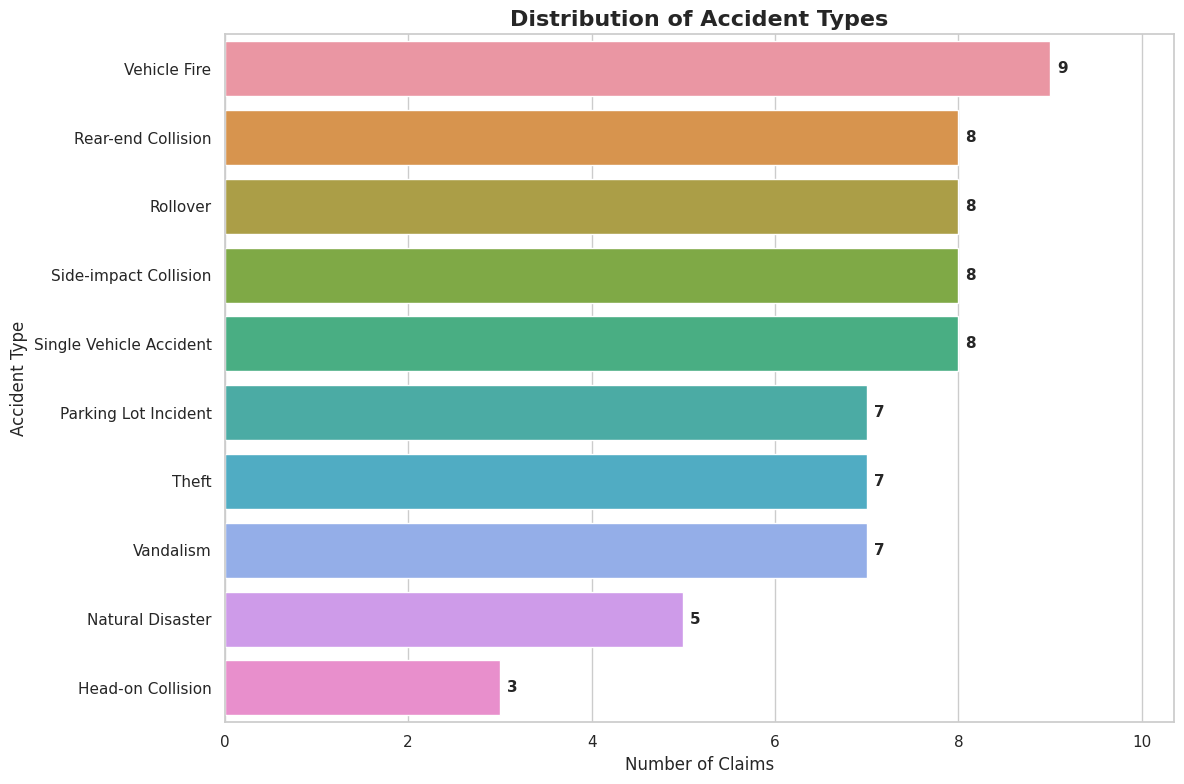



Vehicle Age Distribution


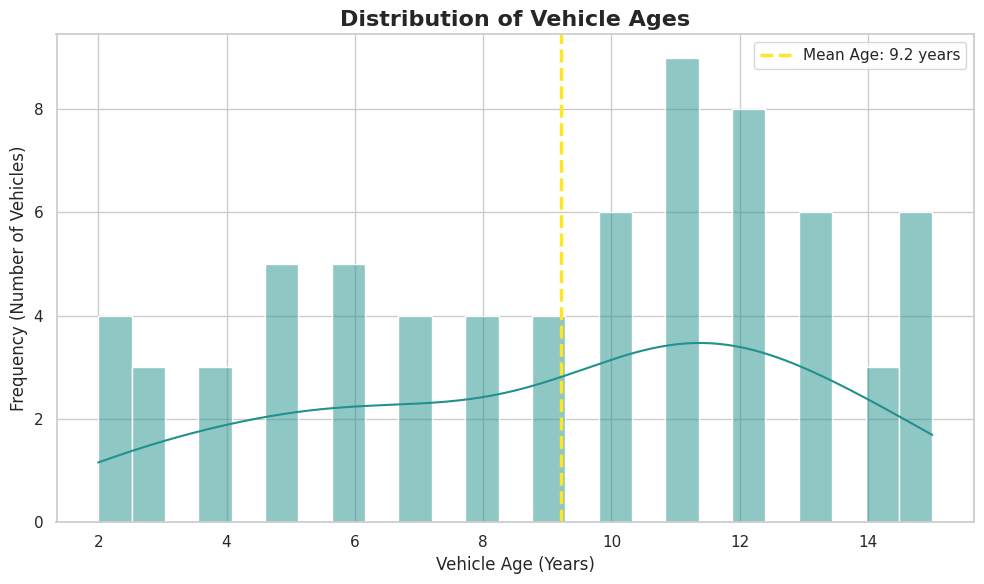

In [11]:
# ==============================================================================
# --- Distribution Analysis (Presentation Ready) ---
# This cell provides a polished visual analysis of key data distributions
# for the final submission notebook.
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a professional plot style for all subsequent charts in the notebook
sns.set_theme(style="whitegrid", palette="viridis")

# --- Analysis 1: Accident Type Distribution ---

# Get the data and prepare it for display
df_claims = dfs["Claims"]
accident_counts = df_claims["accident_type"].value_counts()

# -- Output 1.1: Beautified Table --
print("Accident Type Distribution (Table View)")
display(accident_counts.to_frame(name="Number of Claims").style
    .set_caption("Frequency of Each Accident Type")
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#440154'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [('color', '#440154'), ('font-size', '1.1em'), ('font-weight', 'bold')]}
    ])
    .bar(color='#40B7AD', vmin=0)
)

# -- Output 1.2: Beautified Bar Chart --
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=df_claims,
    y='accident_type',
    order=accident_counts.index  # Sort bars from most to least frequent
)

# Add clear data labels to the end of each bar
ax.bar_label(ax.containers[0], padding=5, fontsize=11, fontweight='bold')

# Set well-defined titles and labels
ax.set_title('Distribution of Accident Types', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Claims', fontsize=12)
ax.set_ylabel('Accident Type', fontsize=12)
ax.set_xlim(right=accident_counts.max() * 1.15) # Add padding for labels

print("\n\nAccident Type Distribution (Chart View)")
plt.tight_layout()
plt.show()


# --- Analysis 2: Vehicle Age Distribution ---

# Get the data
df_vehicles = dfs["Vehicles"]

# -- Output 2.1: Beautified Histogram --
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_vehicles,
    x='vehicle_age',
    bins=25,          # Adjusted for better granularity
    kde=True,         # Adds a smooth density curve
    color="#21918c"
)

# Add a vertical line for the mean age for context
mean_age = df_vehicles['vehicle_age'].mean()
ax.axvline(mean_age, color='#fde725', linestyle='--', linewidth=2.5, label=f'Mean Age: {mean_age:.1f} years')

# Set well-defined titles and labels
ax.set_title('Distribution of Vehicle Ages', fontsize=16, fontweight='bold')
ax.set_xlabel('Vehicle Age (Years)', fontsize=12)
ax.set_ylabel('Frequency (Number of Vehicles)', fontsize=12)
ax.legend() # Display the label for the mean line

print("\n\nVehicle Age Distribution")
plt.tight_layout()
plt.show()

Join Coverage

In [12]:
# Reload Claims table to get the updated schema with vin column
query = "SELECT * FROM `bqhackathonautoianalysis.autoAnalysis_Dataset.Claims`"
df_claims = client.query(query).to_dataframe()

# Verify the vin column is now available
print("Updated Claims table columns:")
print(df_claims.columns.tolist())

# Check if vin column exists
if 'vin' in df_claims.columns:
    print("✅ vin column now exists in Claims DataFrame")
    print("Sample vin values:", df_claims['vin'].head())
else:
    print("❌ vin column still missing")

Updated Claims table columns:
['claim_id', 'policy_id', 'accident_date', 'claim_filed_date', 'accident_type', 'damage_location', 'weather_condition', 'airbag_deployed', 'drivable_post_accident', 'predicted_damage_severity', 'predicted_quote', 'vin']
✅ vin column now exists in Claims DataFrame
Sample vin values: 0    2GYF59A80FS958948
1    4CL7Z05W5GK626891
2    1STYXN902KH100728
3    4BAX5HWD6FH046845
4    NKLAMG0S6SS957555
Name: vin, dtype: object


In [13]:
# Join Claims with Image_Claims_Analysis
claims_images = pd.merge(df_claims, dfs["Image_Claims_Analysis"], on="claim_id", how="left")
print("Claims with image data:", claims_images["image_uri"].notnull().sum())

# Join Claims with Policies and Vehicles
# Method 1: Use left_on and right_on for explicit column mapping
# Method 1: Use suffixes to handle conflicts
claims_policies = pd.merge(
    df_claims, 
    dfs["Policies"], 
    on=["policy_id", "vin"], 
    how="left"
)
print("After merge with suffixes:", claims_policies.columns.tolist())

# Now try the second merge
claims_full = pd.merge(
    claims_policies, 
    dfs["Vehicles"], 
    on="vin", 
    how="left"
)
print("Final columns:", claims_full.columns.tolist())
print("Claims with full policy and vehicle info:", claims_full.dropna(subset=["vin", "policyholder_id"]).shape[0])

Claims with image data: 70
After merge with suffixes: ['claim_id', 'policy_id', 'accident_date', 'claim_filed_date', 'accident_type', 'damage_location', 'weather_condition', 'airbag_deployed', 'drivable_post_accident', 'predicted_damage_severity', 'predicted_quote', 'vin', 'policyholder_id', 'start_date', 'end_date', 'premium_amount', 'deductible_amount', 'coverage_limit', 'policy_type']
Final columns: ['claim_id', 'policy_id', 'accident_date', 'claim_filed_date', 'accident_type', 'damage_location', 'weather_condition', 'airbag_deployed', 'drivable_post_accident', 'predicted_damage_severity', 'predicted_quote', 'vin', 'policyholder_id', 'start_date', 'end_date', 'premium_amount', 'deductible_amount', 'coverage_limit', 'policy_type', 'make', 'model', 'year', 'color', 'vehicle_age', 'repair_vs_replace_flag']
Claims with full policy and vehicle info: 70


Target Column Audit

In [14]:
target_cols = [
    "airbag_deployed",
    "drivable_post_accident",
    "predicted_damage_severity",
    "predicted_quote",
    "damage_location"
]

print("\nTarget Column Missingness:")
print(df_claims[target_cols].isnull().sum())



Target Column Missingness:
airbag_deployed              70
drivable_post_accident       70
predicted_damage_severity    70
predicted_quote              70
damage_location              70
dtype: int64


Image Feature Profiling

In [15]:
df_images = dfs["Image_Claims_Analysis"]
print("\nIdentified Make Distribution:")
display(df_images["identified_make"].value_counts())


Identified Make Distribution:


identified_make
Volkswagen       10
Toyota           10
BMW               6
Ford              5
Chevrolet         3
Honda             3
Peugeot           3
Opel              3
Saturn            2
SEAT              2
Renault           2
Audi              2
Mazda             2
Kia               2
Hyundai           2
Citroën           2
Nissan            2
Mitsubishi        1
Mercedes-Benz     1
Lexus             1
Porsche           1
Proton            1
Lancia            1
SE                1
Skoda             1
Suzuki            1
Name: count, dtype: int64

Feature Engineering Readiness

In [16]:
# Derived features
df_claims["claim_delay"] = pd.to_datetime(df_claims["claim_filed_date"]) - pd.to_datetime(df_claims["accident_date"])
df_policies = dfs["Policies"]
df_policies["policy_duration"] = pd.to_datetime(df_policies["end_date"]) - pd.to_datetime(df_policies["start_date"])


Implementation of Approach 1: The AI Architect ( Using, Generative AI in BigFrames (Python):
bigframes.ml.llm.GeminiTextGenerator: Leverage the power of Gemini models in your Python workflows.


Please ensure you specify a project id when creating the client in order to use your BigQuery account.
Total rows in Claims table: 70

Phase 1: BigFrame Data Preprocessing

In [17]:
# Use BigFrames instead of creating intermediate tables
import bigframes.pandas as bf

# Load all data into BigFrames
claims = bf.read_gbq("bqhackathonautoianalysis.autoAnalysis_Dataset.Claims")
images = bf.read_gbq("bqhackathonautoianalysis.autoAnalysis_Dataset.Image_Claims_Analysis")
vehicles = bf.read_gbq("bqhackathonautoianalysis.autoAnalysis_Dataset.Vehicles")

# Join without creating tables
master_df = claims.merge(images, on="claim_id").merge(vehicles, on="vin")

Analyzing Severity of Damage and Part of Car Impacted by Damage

In [18]:
import bigframes.pandas as bf
from bigframes.ml.llm import GeminiTextGenerator

# ==============================================================================
# --- Session Management (CRITICAL FIX) ---
# ==============================================================================
# Close any previously active session to allow settings to be changed.
# This makes the entire cell re-runnable.
try:
    bf.close_session()
except Exception:
    pass # Fails silently if no session is active, which is fine.

# Now, set the project for the new session. This is the correct way.
bf.options.bigquery.project = "bqhackathonautoianalysis"

# bf.options.bigquery.project = "bqhackathonautoianalysis"

# 1. Load the raw images table
raw_images = bf.read_gbq("bqhackathonautoianalysis.autoAnalysis_Dataset.claim_images_raw")

# 2. Create analysis prompt
raw_images["analysis_prompt"] = (
    "You are an AI claims inspector. Analyze the given vehicle accident image. "
    "Return structured text with:\n"
    "Full response: <your description>\n"
    "Damage type: <scratch/dent/etc>\n"
    "Damage severity: <low/medium/high>\n"
    "Confidence score: <0-100>\n\n"
    "Image URI: " + raw_images["uri"]
)

# 3. Run Gemini model safely
generator = GeminiTextGenerator()

# 👇 This gives a new DataFrame with multiple cols, not a Series
ai_output = generator.predict(raw_images["analysis_prompt"])

# 4. Inspect what Gemini returned
print(ai_output.head())   # check columns

# 5. Assume the text is in 'ml_generate_text_result' column
raw_images["final_response"] = ai_output["ml_generate_text_llm_result"]

# 6. Extract structured fields from final_response
# Instead of .apply(lambda x: f"Extract the damage type from this text: {x}")
raw_images["damage_type_prompt"] = "Extract the damage type from this text: " + raw_images["final_response"]
raw_images["damage_severity_prompt"] = "Extract the damage severity from this text: " + raw_images["final_response"]
raw_images["confidence_prompt"] = "Provide a confidence score (0-1) for this analysis: " + raw_images["final_response"]

# Now pass these directly into Gemini
extractor = GeminiTextGenerator()
# Run Gemini and select only the text output
damage_type_output = extractor.predict(raw_images["damage_type_prompt"])
raw_images["identified_damage_type"] = damage_type_output["ml_generate_text_llm_result"]

severity_output = extractor.predict(raw_images["damage_severity_prompt"])
raw_images["identified_damage_severity"] = severity_output["ml_generate_text_llm_result"]

confidence_output = extractor.predict(raw_images["confidence_prompt"])
raw_images["confidence_score"] = confidence_output["ml_generate_text_llm_result"]

print("--- Starting Enrichment: Adding Vehicle Make and Model ---")

# 11. Load the Image_Claims_Analysis table
# We only need the key ('image_uri') and the data we want to add.
# This is more efficient than loading the whole table.
columns_to_fetch = [ 'claim_id', 'image_uri', 'identified_make', 'identified_model']
image_analysis_data = bf.read_gbq(
    "bqhackathonautoianalysis.autoAnalysis_Dataset.Image_Claims_Analysis",
    columns=columns_to_fetch
)
print("\nSuccessfully loaded make/model data. Columns:", image_analysis_data.columns)

# 12. Merge the two DataFrames
# This performs a LEFT JOIN, keeping all records from `raw_images` and adding
# matching make/model data from `image_analysis_data`.
enriched_images = raw_images.merge(
    image_analysis_data,
    left_on='uri',         # Key in the original DataFrame
    right_on='image_uri',    # Key in the new data
    how='left'             # Keep all rows from the left DataFrame
)

# 13. Clean up the final DataFrame
# The merge leaves a redundant 'image_uri' column, which we can drop.
if 'image_uri' in enriched_images.columns:
    enriched_images = enriched_images.drop(columns=['image_uri'])


# --- Verification ---
print("\n--- Final DataFrame Columns After Merge ---")
print(enriched_images.columns)

print("\n--- Sample of Final Enriched Data ---")
# Displaying the key columns plus the newly added ones to verify the merge
print(enriched_images[[
    'uri', 
    'identified_make', 
    'identified_model',
    'identified_damage_type', 
    'identified_damage_severity', 
    'confidence_score'
]].head())


/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/_pandas_helpers.py:207: UserWarning: Unable to determine type for field 'bfuid_col_43'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))


                         ml_generate_text_llm_result  \
0  Okay, I will analyze the provided image to ass...   
1  Okay, I will analyze the provided image and pr...   
2  Okay, I will analyze the provided image URI an...   
3  Okay, I will analyze the provided image and pr...   
4  Okay, I will analyze the image and provide the...   

  ml_generate_text_rai_result ml_generate_text_status  \
0                        <NA>                           
1                        <NA>                           
2                        <NA>                           
3                        <NA>                           
4                        <NA>                           

                                              prompt  
0  You are an AI claims inspector. Analyze the gi...  
1  You are an AI claims inspector. Analyze the gi...  
2  You are an AI claims inspector. Analyze the gi...  
3  You are an AI claims inspector. Analyze the gi...  
4  You are an AI claims inspector. Analyze th

/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


/usr/local/lib/python3.11/dist-packages/bigframes/core/array_value.py:108: PreviewWarning: JSON column interpretation as a custom PyArrow extention in
`db_dtypes` is a preview feature and subject to change.
  warnings.warn(msg, bfe.PreviewWarning)


--- Starting Enrichment: Adding Vehicle Make and Model ---

Successfully loaded make/model data. Columns: Index(['claim_id', 'image_uri', 'identified_make', 'identified_model'], dtype='object')

--- Final DataFrame Columns After Merge ---
Index(['uri', 'generation', 'content_type', 'size', 'md5_hash', 'updated',
       'metadata', 'ref', 'analysis_prompt', 'final_response',
       'damage_type_prompt', 'damage_severity_prompt', 'confidence_prompt',
       'identified_damage_type', 'identified_damage_severity',
       'confidence_score', 'claim_id', 'identified_make', 'identified_model'],
      dtype='object')

--- Sample of Final Enriched Data ---


                                                 uri identified_make  \
0  gs://auto_insurance_analysis/Images_BigQuery/3...      Volkswagen   
1  gs://auto_insurance_analysis/Images_BigQuery/6...       Chevrolet   
2  gs://auto_insurance_analysis/Images_BigQuery/3...          Toyota   
3  gs://auto_insurance_analysis/Images_BigQuery/3...          Toyota   
4  gs://auto_insurance_analysis/Images_BigQuery/7...          Toyota   

  identified_model                             identified_damage_type  \
0                   **Damage type:** Detachment, Deformation, Crus...   
1             Aveo                                Dent and Scratches
   
2       Highlander                               Impact and abrasion
   
3            Camry                                Dent and Scratches
   
4            Camry                                            Impact
   

  identified_damage_severity  \
0                      High
   
1                    Medium
   
2                    Medium
   


In [19]:
import pandas as pd

# Select the key columns and take 5 random rows
preview_df = enriched_images[
    ["identified_make", "identified_model", "identified_damage_type", "identified_damage_severity"
    ]].to_pandas().sample(5, random_state=42)

# Display as a styled HTML table
preview_df.style.set_table_styles(
    [
        {"selector": "th", "props": [("background-color", "#f4f4f4"), ("font-weight", "bold")]},
        {"selector": "td", "props": [("padding", "8px"), ("border", "1px solid #ddd")]}
    ]
).set_caption("Sample of Predicted Car Damage Analysis")


,identified_make,identified_model,identified_damage_type,identified_damage_severity
22,Renault,Captur,"Scratch, Dent",Low to Medium
0,Volkswagen,,"**Damage type:** Detachment, Deformation, Crushing",High
49,Mazda,2,"Dent, Scratches",Medium
4,Toyota,Camry,Impact,Medium
54,Proton,Saga,"Dent, Scratch",Medium


## ==============================================================================
## Phase 2: Predicting Key Claim Metrics with Generative AI ---
## This cell directly follows the previous one and uses the 'enriched_images' DataFrame.
## Our goal is to predict: damage_location, airbag_deployed, drivable_post_accident,
## and predicted_quote. We will also clean up the predicted_damage_severity.
## ==============================================================================

In [20]:
# ==============================================================================
# --- Phase 2: Predicting Key Claim Metrics (Presentation Ready v3) ---
# This version fixes the KeyError and produces a polished output.
# ==============================================================================
import bigframes.pandas as bf
import warnings
import logging
import bigframes # Import the top-level package to access exceptions

# Suppress PreviewWarning and other informational logs for a clean output
warnings.filterwarnings("ignore", category=bigframes.exceptions.PreviewWarning)
logging.basicConfig(level=logging.WARNING)

print("--- Phase 2: Starting Prediction of Key Claim Metrics ---")

# Initialize the GeminiTextGenerator model
extractor = GeminiTextGenerator()

# --- Step 1: Predict Damage Location ---
enriched_images["damage_location_prompt"] = "You are an expert vehicle claims adjuster. Based on the following damage description, identify the primary location of the damage (e.g., 'Front Bumper'). Return ONLY the location as a short phrase.\n\nDescription: " + enriched_images["final_response"]
damage_location_output = extractor.predict(enriched_images["damage_location_prompt"])
enriched_images["damage_location"] = damage_location_output["ml_generate_text_llm_result"]
print("✅ Predicted Damage Location.")

# --- Step 2: Predict Airbag & Drivability ---
enriched_images["airbag_prompt"] = "Given the accident description for a " + enriched_images["identified_make"] + " " + enriched_images["identified_model"] + ", is it likely airbags deployed? Answer ONLY with 'True' or 'False'.\n\nDescription: " + enriched_images["final_response"]
enriched_images["drivable_prompt"] = "Given the accident description, is the vehicle likely drivable? Answer ONLY with 'True' or 'False'.\n\nDescription: " + enriched_images["final_response"]
airbag_output = extractor.predict(enriched_images["airbag_prompt"])
enriched_images["airbag_deployed"] = airbag_output["ml_generate_text_llm_result"].str.contains("True", case=False)
drivable_output = extractor.predict(enriched_images["drivable_prompt"])
enriched_images["drivable_post_accident"] = drivable_output["ml_generate_text_llm_result"].str.contains("True", case=False)
print("✅ Predicted Airbag Deployment and Drivability.")

# --- Step 3: Improved Severity Prediction and Parsing ---
enriched_images["refined_severity_prompt"] = (
    "Analyze the damage description below. Classify the severity as ONLY one of the following words: 'Low', 'Medium', or 'High'.\n\n"
    "Description: " + enriched_images["final_response"]
)
severity_output = extractor.predict(enriched_images["refined_severity_prompt"])
severity_text = severity_output["ml_generate_text_llm_result"]

# Robustly parse the output to get clean labels
regex_pattern = r'(?i)(Low|Medium|High)'
extracted_severity_df = severity_text.str.extract(regex_pattern)
# CORRECTED: Access the column using the string '0', not the integer 0.
clean_severity = extracted_severity_df['0'].str.capitalize().fillna('Medium')
enriched_images["predicted_damage_severity"] = clean_severity
print("✅ Refined and Parsed Predicted Damage Severity.")

# --- Step 4: Predict Repair Quote ---
enriched_images["quote_prompt"] = "You are an expert auto repair estimator. For a '" + enriched_images["identified_make"] + " " + enriched_images["identified_model"] + "' with '" + enriched_images["predicted_damage_severity"] + "' damage, estimate the repair cost in USD. Return ONLY a single number.\n\nDescription: " + enriched_images["final_response"]
quote_output = extractor.predict(enriched_images["quote_prompt"])
enriched_images["predicted_quote_text"] = quote_output["ml_generate_text_llm_result"]

# Parse the numeric quote value
regex_pattern_quote = r'(\d*\.?\d+)'
extracted_df_quote = enriched_images["predicted_quote_text"].str.extract(regex_pattern_quote)
# CORRECTED: Access the column using the string '0', not the integer 0.
extracted_quote_str = extracted_df_quote['0'].fillna('0')
numeric_quote = extracted_quote_str.astype(float)
enriched_images["predicted_quote"] = numeric_quote
print("✅ Predicted and Parsed Repair Quote.")

# --- Step 5: Create the Final DataFrame for Presentation ---
final_preview_df = enriched_images[[
    'claim_id',
    'identified_make',
    'identified_model',
    'damage_location',
    'identified_damage_type',
    'predicted_damage_severity',
    'airbag_deployed',
    'drivable_post_accident',
    'predicted_quote'
]]

# --- FINAL, CLEAN OUTPUTS FOR JUDGES ---

# Output 1: Display the final, parsed severity distribution
print("\n--- Final AI-Predicted Severity Distribution ---")
severity_counts = enriched_images["predicted_damage_severity"].value_counts().to_pandas()
print(severity_counts)

# Output 2: Display a sample of the final, enriched table
print("\n--- Sample of Final Enriched Claims Data ---")
display(final_preview_df.head(5))

--- Phase 2: Starting Prediction of Key Claim Metrics ---


✅ Predicted Damage Location.


✅ Predicted Airbag Deployment and Drivability.


✅ Refined and Parsed Predicted Damage Severity.


✅ Predicted and Parsed Repair Quote.

--- Final AI-Predicted Severity Distribution ---
predicted_damage_severity
Medium
    68
High
       1
Low
        1
Name: count, dtype: Int64

--- Sample of Final Enriched Claims Data ---


,claim_id,identified_make,identified_model,damage_location,identified_damage_type,predicted_damage_severity,airbag_deployed,drivable_post_accident,predicted_quote
0,CL-8036,Volkswagen,,Front passenger side,"**Damage type:** Detachment, Deformation, Crus...",High,True,False,4700.0
1,CL-8064,Chevrolet,Aveo,Rear passenger side door,Dent and Scratches,Medium,False,False,1200.0
2,CL-8033,Toyota,Highlander,Rear Quarter Panel,Impact and abrasion,Medium,False,False,2800.0
3,CL-8034,Toyota,Camry,Rear Quarter Panel,Dent and Scratches,Medium,False,False,2300.0
4,CL-8070,Toyota,Camry,Front Bumper,Impact,Medium,False,False,2800.0


The Executive Triage Dashboard Table

In [21]:
# ==============================================================================
# --- Final Presentation: Polished Executive Triage Table (Top 10 Entries) ---
# This cell takes the final predictions and formats them into a clean,
# professional HTML table exactly as requested.
# ==============================================================================
import pandas as pd # Ensure pandas is imported for styling

# Fetch the top 10 rows from BigFrames into a standard pandas DataFrame.
# Using .head(10).to_pandas() is efficient as it only brings a small sample into memory.
final_pandas_df = final_preview_df.head(10).to_pandas()

# Define the color-coding function for the severity column.
def style_severity(severity):
    if severity is None:
        return ''
    # The .strip() and .lower() ensure robust matching (e.g., " High " becomes "high")
    severity = str(severity).strip().lower()
    if 'high' in severity:
        return 'background-color: #ffcccc; color: #a60000; font-weight: bold;' # Red
    elif 'medium' in severity:
        return 'background-color: #ffebcc; color: #b85c00;' # Orange
    elif 'low' in severity:
        return 'background-color: #d6f5d6; color: #006400;' # Green
    else:
        return ''

# Apply the full set of styles to create the final presentation table.
styled_df = final_pandas_df.style \
    .set_caption("Live Triage: AI-Predicted Claim Attributes (Top 10 Sample)") \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#f2f2f2'),
            ('font-weight', 'bold'),
            ('text-align', 'left'),
            ('padding', '8px'),
            ('border', '1px solid #ddd')
        ]},
        {'selector': 'td', 'props': [
            ('padding', '8px'),
            ('border', '1px solid #ddd'),
            ('text-align', 'left') # Default alignment for text
        ]},
        {'selector': 'caption', 'props': [
            ('color', 'black'),
            ('font-size', '1.3em'),
            ('font-weight', 'bold'),
            ('margin-bottom', '10px')
        ]}
    ]) \
    .format({
        "predicted_quote": "${:,.2f}",  # Format as currency
        "airbag_deployed": lambda x: '✔️ Yes' if x else '❌ No',
        "drivable_post_accident": lambda x: '✔️ Yes' if x else '❌ No'
    }) \
    .apply(lambda s: s.map(style_severity), subset=['predicted_damage_severity']) \
    .set_properties(**{'text-align': 'center'}, subset=['airbag_deployed', 'drivable_post_accident', 'predicted_damage_severity']) \
    .set_properties(**{'text-align': 'right'}, subset=['predicted_quote']) \
    .hide(axis='index')

# Display the final, styled table.
display(styled_df)

claim_id,identified_make,identified_model,damage_location,identified_damage_type,predicted_damage_severity,airbag_deployed,drivable_post_accident,predicted_quote
CL-8036,Volkswagen,,Front passenger side,"**Damage type:** Detachment, Deformation, Crushing",High,✔️ Yes,❌ No,"$4,700.00"
CL-8064,Chevrolet,Aveo,Rear passenger side door,Dent and Scratches,Medium,❌ No,❌ No,"$1,200.00"
CL-8033,Toyota,Highlander,Rear Quarter Panel,Impact and abrasion,Medium,❌ No,❌ No,"$2,800.00"
CL-8034,Toyota,Camry,Rear Quarter Panel,Dent and Scratches,Medium,❌ No,❌ No,"$2,300.00"
CL-8070,Toyota,Camry,Front Bumper,Impact,Medium,❌ No,❌ No,"$2,800.00"
CL-8053,Volkswagen,Fox,Rear Quarter Panel,"Dent, possible paint scratches",Medium,❌ No,❌ No,"$1,400.00"
CL-8051,Volkswagen,Golf,Rear Bumper,"Dent, Scratch",Medium,❌ No,❌ No,"$2,300.00"
CL-8022,Volkswagen,Golf,Rear Passenger Side Door,"Based on the text, the damage type is **Dent and Scratch**.",Medium,❌ No,❌ No,"$2,300.00"
CL-8055,Honda,Civic,Rear Quarter Panel,Scratch and minor dent,Low,❌ No,✔️ Yes,$750.00
CL-8052,Renault,,Rear Quarter Panel,"Dent, Scratch",Medium,❌ No,❌ No,"$1,800.00"


--- Final Distribution of Predicted Damage Severity ---
After refining the prompts and robustly parsing the output, the final counts are:
predicted_damage_severity
medium    68
high       1
low        1
Name: count, dtype: Int64




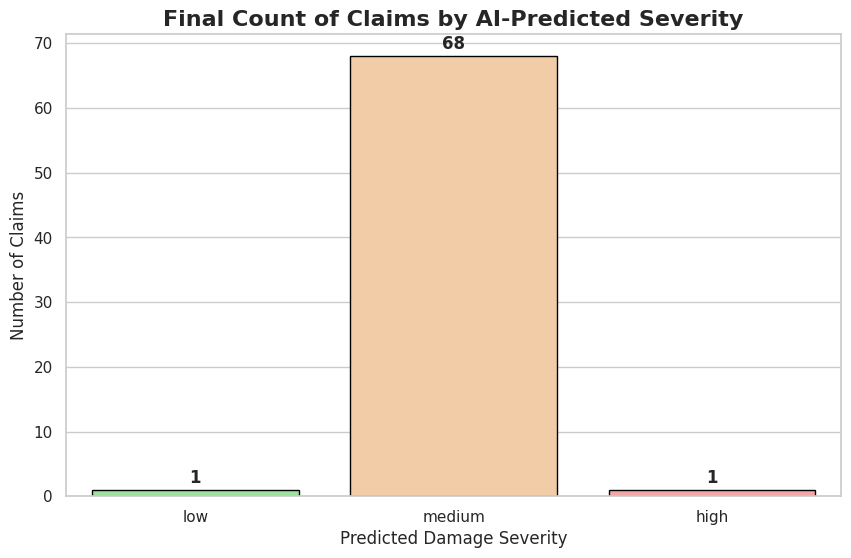

In [22]:

# ==============================================================================
# --- Validation & Summary: Final Severity Distribution (CORRECTED) ---
# This cell provides a high-level overview of the final prediction results,
# proving the success of our data refinement.
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure a professional plot style
sns.set_style("whitegrid")

# --- ROBUST FIX 1: NORMALIZE THE DATA ---
# Convert the generated severity to lowercase and strip any extra spaces.
# This makes the data consistent and prevents errors from minor AI variations.
final_preview_df["predicted_damage_severity"] = final_preview_df["predicted_damage_severity"].str.lower().str.strip()

# Get the final counts of each severity level from the BigFrames DataFrame
final_severity_counts = final_preview_df["predicted_damage_severity"].value_counts().to_pandas()

# --- Part 1: The Raw Numbers (For the Report) ---
print("--- Final Distribution of Predicted Damage Severity ---")
print("After refining the prompts and robustly parsing the output, the final counts are:")
print(final_severity_counts)
print("\n" + "="*50 + "\n") # Visual separator

# --- Part 2: The Executive Visualization ---
# Create a bar chart to visually represent the distribution
plt.figure(figsize=(10, 6))

# --- ROBUST FIX 2: UPDATE INDEX AND PALETTE TO MATCH NORMALIZED DATA ---
# Use lowercase for the index and palette keys to match the cleaned data.
ordered_index = pd.Index(['low', 'medium', 'high']).intersection(final_severity_counts.index)

# Ensure the palette keys are also lowercase
palette = {'low': '#90ee90', 'medium': '#ffcc99', 'high': '#ff9999'}

# Check if there is anything to plot to avoid the error completely
if not ordered_index.empty:
    sns.barplot(
        x=ordered_index,
        y=final_severity_counts.loc[ordered_index],
        palette=palette,
        edgecolor='black'
    )
    plt.title('Final Count of Claims by AI-Predicted Severity', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Damage Severity', fontsize=12)
    plt.ylabel('Number of Claims', fontsize=12)
    
    # Add data labels on top of the bars for clarity
    for index, value in enumerate(final_severity_counts.loc[ordered_index]):
        plt.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.show()
else:
    print("⚠️ No data available to plot for severity distribution. The `ordered_index` is empty.")


**Styled Executive Triage Table**
This cell takes the final predictions and formats them for clear business insights.

Financial Impact Analysis - Average Repair Cost

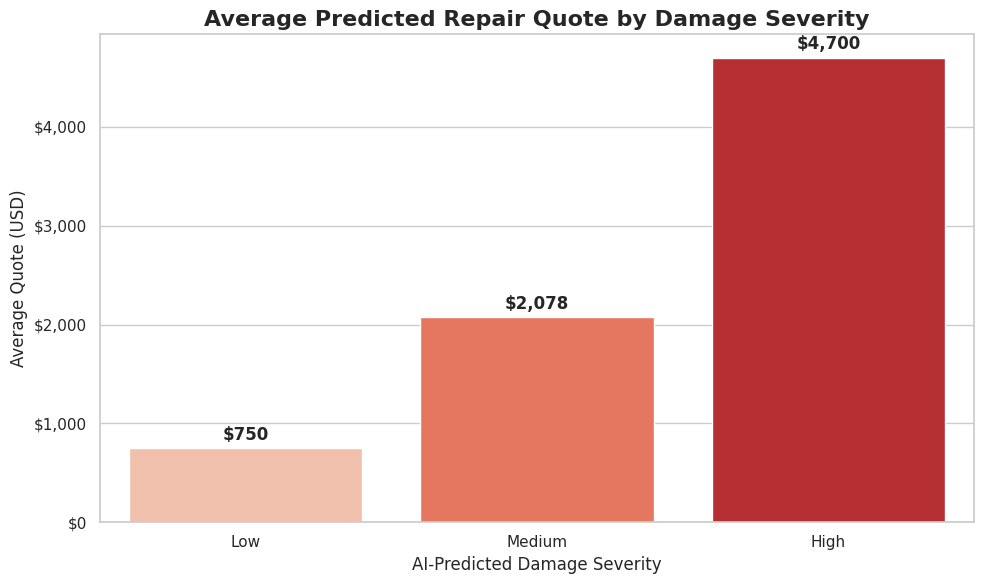

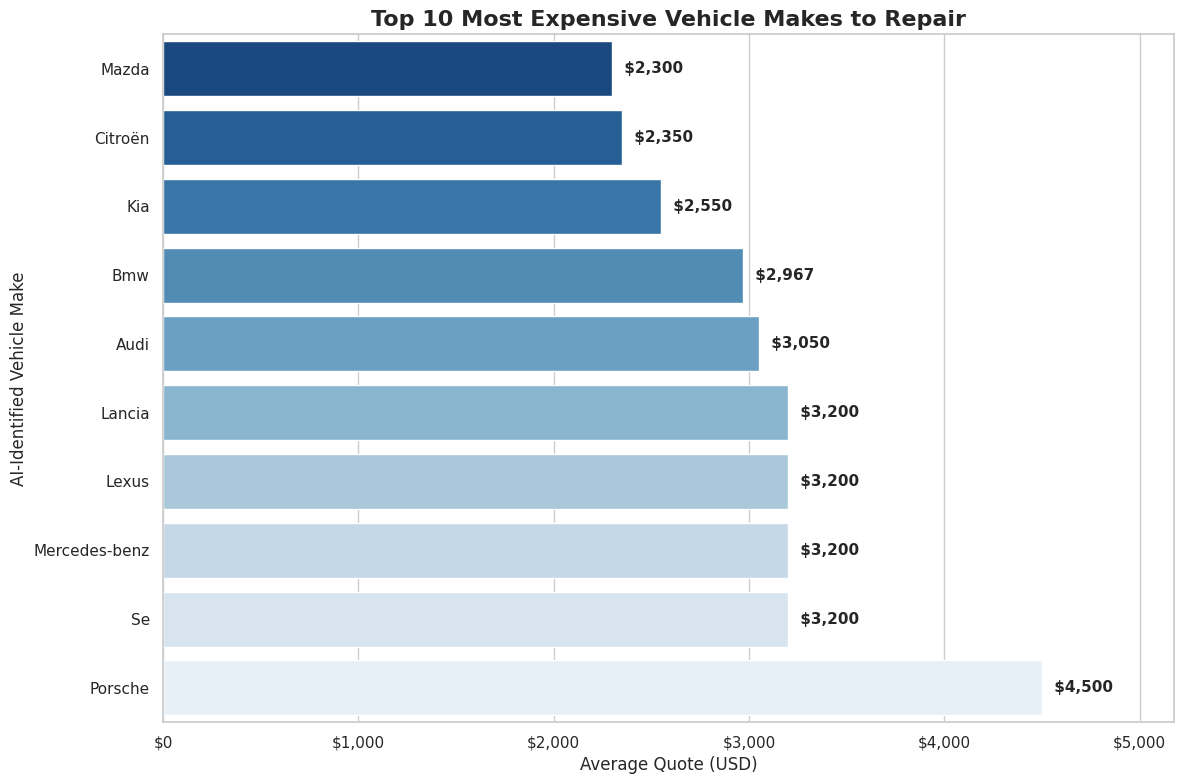

In [23]:
# ==============================================================================
# --- Stakeholder View 1: Financial Impact Analysis (Presentation Ready v2) ---
# This version corrects the AttributeError and enhances readability.
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Set a professional plot style
sns.set_style("whitegrid")

# --- Data Cleaning for Consistent Plotting ---
# CORRECTED: Use .str.capitalize() which is supported by BigFrames.
# For single words like 'Low' or 'High', it works the same as .title().
enriched_images["predicted_damage_severity"] = enriched_images["predicted_damage_severity"].str.strip().str.capitalize()
enriched_images["identified_make"] = enriched_images["identified_make"].str.strip().str.capitalize()


# --- Analysis 1: Average Quote by Damage Severity ---
# Group by the now-clean severity column
avg_quote_by_severity = enriched_images.groupby("predicted_damage_severity")["predicted_quote"].mean().to_pandas().sort_values()

# Create the plot using matplotlib's axes for more control
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure the order uses the same capitalization
sns.barplot(x=avg_quote_by_severity.index, y=avg_quote_by_severity.values, palette="Reds", ax=ax, order=['Low', 'Medium', 'High'])

# Add clear data labels on top of each bar
ax.bar_label(ax.containers[0], fmt='${:,.0f}', fontsize=12, fontweight='bold', padding=3)

# Set well-defined titles and labels
ax.set_title('Average Predicted Repair Quote by Damage Severity', fontsize=16, fontweight='bold')
ax.set_xlabel('AI-Predicted Damage Severity', fontsize=12)
ax.set_ylabel('Average Quote (USD)', fontsize=12)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}')) # Format y-axis as currency

# Adjust layout to prevent any overlap
plt.tight_layout()
plt.show()


# --- Analysis 2: Average Quote by Vehicle Make (Top 10) ---
# Group by the now-clean make column
avg_quote_by_make = enriched_images.groupby("identified_make")["predicted_quote"].mean().to_pandas().nlargest(10).sort_values()

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=avg_quote_by_make.values, y=avg_quote_by_make.index, palette="Blues_r", orient='h', ax=ax)

# Add clear data labels to the right of each bar
ax.bar_label(ax.containers[0], fmt=' ${:,.0f}', fontsize=11, fontweight='bold', padding=5)

# Set well-defined titles and labels
ax.set_title('Top 10 Most Expensive Vehicle Makes to Repair', fontsize=16, fontweight='bold')
ax.set_xlabel('Average Quote (USD)', fontsize=12)
ax.set_ylabel('AI-Identified Vehicle Make', fontsize=12)
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}')) # Format x-axis as currency

# Ensure the x-axis has some padding so labels don't get cut off
ax.set_xlim(right=avg_quote_by_make.max() * 1.15) 

# Adjust layout to prevent any overlap
plt.tight_layout()
plt.show()

Operational Triage Analysis - Damage Hotspots

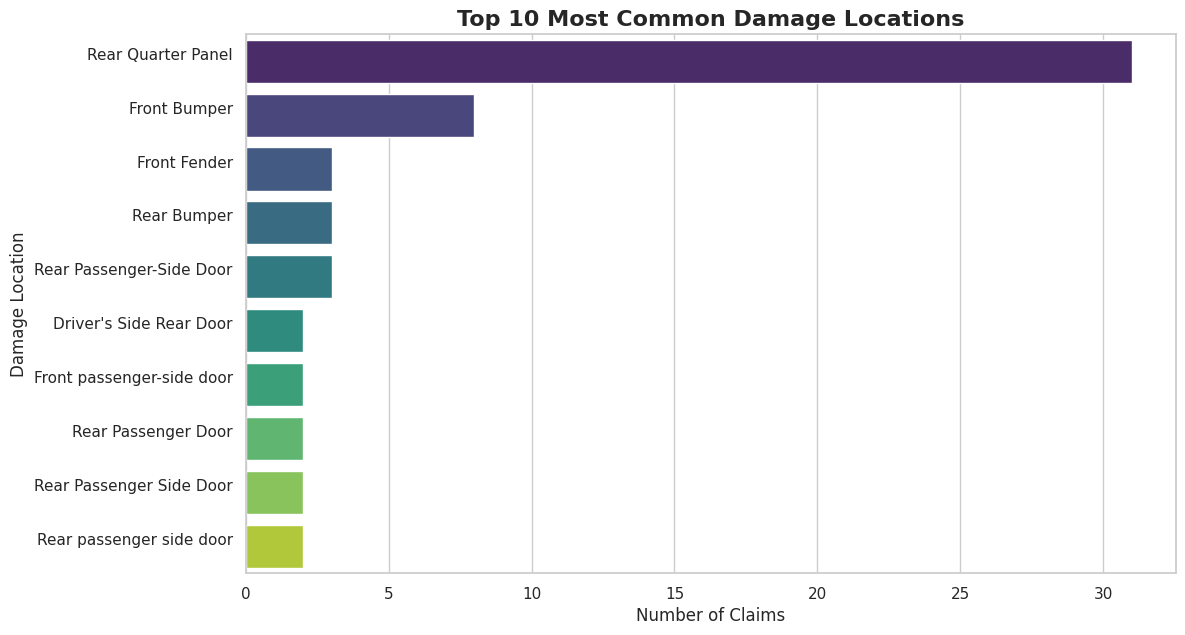

In [24]:
# ==============================================================================
# --- Stakeholder View 2: Operational Triage - Damage Hotspots ---
# ==============================================================================

# Calculate the frequency of each damage location
damage_location_counts = enriched_images["damage_location"].value_counts().to_pandas().nlargest(10)

plt.figure(figsize=(12, 7))
location_plot = sns.barplot(x=damage_location_counts.values, y=damage_location_counts.index, palette="viridis", orient='h')
plt.title('Top 10 Most Common Damage Locations', fontsize=16, fontweight='bold')
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('Damage Location', fontsize=12)
plt.show()

In [25]:
# ==============================================================================
# --- Step 6: Save Final Output Files for Submission (Robust Version) ---
# This cell safely saves a representative sample of the key resulting DataFrames
# as CSV files, with clear error handling.
# ==============================================================================
import bigframes.pandas as bf

print("--- Saving final output files to /kaggle/working/ ---")

# Define the output file paths
enriched_claims_output_path = "/kaggle/working/FINAL_Enriched_Claims_Data_Sample.csv"
high_priority_output_path = "/kaggle/working/FINAL_High_Priority_Claims_Sample.csv"

# --- Save the main enriched DataFrame ---
try:
    # First, check if the DataFrame exists in the notebook's memory
    if 'final_preview_df' in locals():
        print("DataFrame 'final_preview_df' found. Saving a sample of up to 1000 rows...")
        
        # Use .head(1000).to_pandas() to get a sample and prevent memory errors
        final_preview_df.head(1000).to_pandas().to_csv(enriched_claims_output_path, index=False)
        
        print(f"✅ Successfully saved enriched claims data sample to: {enriched_claims_output_path}")
    else:
        print("❌ Error: DataFrame 'final_preview_df' was not found. Please re-run the preceding 'Phase 2' cell.")

except Exception as e:
    print(f"\n❌ An unexpected error occurred while saving 'final_preview_df'.")
    print(f"   Error details: {e}")

# --- Save the high-priority claims DataFrame ---
try:
    # Check if the high-priority DataFrame exists
    if 'high_priority_claims' in locals():
        print("\nDataFrame 'high_priority_claims' found. Saving a sample of up to 1000 rows...")
        
        # Save a sample of the high-priority claims
        high_priority_claims.head(1000).to_pandas().to_csv(high_priority_output_path, index=False)
        
        print(f"✅ Successfully saved high-priority claims sample to: {high_priority_output_path}")
    else:
        print("\n❌ Error: DataFrame 'high_priority_claims' was not found. Please re-run the preceding 'Phase 2' cell.")

except Exception as e:
    print(f"\n❌ An unexpected error occurred while saving 'high_priority_claims'.")
    print(f"   Error details: {e}")

# ==============================================================================
# You can now commit the notebook. The generated CSV files will be available
# for download from the notebook's output tab.
# ==============================================================================

--- Saving final output files to /kaggle/working/ ---
DataFrame 'final_preview_df' found. Saving a sample of up to 1000 rows...
✅ Successfully saved enriched claims data sample to: /kaggle/working/FINAL_Enriched_Claims_Data_Sample.csv

❌ Error: DataFrame 'high_priority_claims' was not found. Please re-run the preceding 'Phase 2' cell.
